In [1]:
# import the library
%matplotlib inline

import ast
import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler

import bokeh
import bokeh.plotting as plotting
from bokeh.plotting import figure, show, ColumnDataSource
from bokeh.tile_providers import CARTODBPOSITRON
plotting.output_notebook()

sns.set_style('whitegrid')

Loading BokehJS ...

# Problem definition

Cluster actors based on number of movies played, movie budget and populaity 

# Load the data

In [2]:
df = pd.read_csv('data/movies_new.csv')
df.head()

,id,title,budget,revenue,production_countries,release_date,popularity,vote_average,vote_count,genres,production_companies,belongs_to_collection,cast,keywords
0,36523,Felix The Cat: The Movie,9000000,1964253.0,"[{'iso_3166_1': 'DE', 'name': 'Germany'}, {'is...",1988-10-01,0.030576,3.7,5.0,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...","[{'name': 'Pannónia Filmstúdió', 'id': 48669},...",0,"[{'cast_id': 1, 'character': 'Felix the Cat (V...","[{'id': 9820, 'name': 'alternate dimension'}, ..."
1,68351,Sankofa,1000000,2691899.0,"[{'iso_3166_1': 'BF', 'name': 'Burkina Faso'},...",1993-05-28,0.045860,6.9,5.0,"[{'id': 18, 'name': 'Drama'}]","[{'name': 'Channel Four Films', 'id': 181}, {'...",0,"[{'cast_id': 6, 'character': 'Sankofa', 'credi...","[{'id': 409, 'name': 'africa'}, {'id': 2831, '..."
2,285908,The Last Breath,3800000,559298.0,"[{'iso_3166_1': 'CA', 'name': 'Canada'}]",1999-03-25,0.072704,4.0,2.0,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...","[{'name': 'Lions Gate Films', 'id': 35}]",0,"[{'cast_id': 0, 'character': 'Lauren Vaillanco...","[{'id': 10714, 'name': 'serial killer'}]"
3,121173,Voracious,11178,34659.0,"[{'iso_3166_1': 'PH', 'name': 'Philippines'}]",2012-09-05,0.079287,8.0,1.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","[{'name': 'APT Entertainment', 'id': 8355}, {'...",0,"[{'cast_id': 16, 'character': 'Rene', 'credit_...","[{'id': 4694, 'name': 'staged death'}, {'id': ..."
4,110669,Wabash Avenue,2115000,2039000.0,"[{'iso_3166_1': 'US', 'name': 'United States o...",1950-03-31,0.109913,7.0,1.0,"[{'id': 10402, 'name': 'Music'}]",[{'name': 'Twentieth Century Fox Film Corporat...,0,"[{'cast_id': 1004, 'character': 'Ruby Summers'...","[{'id': 4344, 'name': 'musical'}, {'id': 4497,..."


In [3]:

df['release_date'] = pd.to_datetime(df['release_date'])
df['year'] = df['release_date'].dt.year
print(df.dtypes)

#Setting cast, production_companies, genres and keywords types to a list of dictionaries

df['cast'] = df['cast'].astype(str)
df['production_countries'] = df['production_countries'].astype(str)
df['genres'] = df['genres'].astype(str)
# df['production_companies'] = df['production_companies'].astype(str)

df['genres'] = df['genres'].apply(lambda x: ast.literal_eval(x))
# df['production_companies'] = df['production_companies'].apply(lambda x: ast.literal_eval(x))
df['cast'] = df['cast'].apply(lambda x: ast.literal_eval(x))
df['production_countries'] = df['production_countries'].apply(lambda x: ast.literal_eval(x))

id                                int64
title                            object
budget                            int64
revenue                         float64
production_countries             object
release_date             datetime64[ns]
popularity                      float64
vote_average                    float64
vote_count                      float64
genres                           object
production_companies             object
belongs_to_collection            object
cast                             object
keywords                         object
year                              int64
dtype: object


Choosing columns

In [4]:
df = df[['title', 'budget', 'year', 'revenue', 'cast', 'production_countries', 'vote_average', 'vote_count', 'genres']].copy()
print(df.head(5))

                      title   budget  year    revenue  \
0  Felix The Cat: The Movie  9000000  1988  1964253.0   
1                   Sankofa  1000000  1993  2691899.0   
2           The Last Breath  3800000  1999   559298.0   
3                 Voracious    11178  2012    34659.0   
4             Wabash Avenue  2115000  1950  2039000.0   

                                                cast  \
0  [{'cast_id': 1, 'character': 'Felix the Cat (V...   
1  [{'cast_id': 6, 'character': 'Sankofa', 'credi...   
2  [{'cast_id': 0, 'character': 'Lauren Vaillanco...   
3  [{'cast_id': 16, 'character': 'Rene', 'credit_...   
4  [{'cast_id': 1004, 'character': 'Ruby Summers'...   

                                production_countries  vote_average  \
0  [{'iso_3166_1': 'DE', 'name': 'Germany'}, {'is...           3.7   
1  [{'iso_3166_1': 'BF', 'name': 'Burkina Faso'},...           6.9   
2           [{'iso_3166_1': 'CA', 'name': 'Canada'}]           4.0   
3      [{'iso_3166_1': 'PH', 'name': 'Ph

# Feature Engineering 

Select a period

In [5]:
df = df[(df['year']>=2000)]
del df['year']
print(df.shape)

(3112, 8)


Keeping only movies which were produced in USA as the budget might be marked in US although in reality its not

In [6]:
df.reset_index(drop=True, inplace=True)
index_extractor = lambda df, field, value: [idx for idx, entries in enumerate(df[field]) for item in entries if value in item['name']]
list_creator = lambda df, idx: [1 if i in idx else 0 for i in df.index]

#Extracting list of countries
l=[]
for i, item in enumerate(df['production_countries']):
    for cell in item:
        l.append(cell['name'])
p_name, p_count = np.unique(np.array(l), return_counts=True)

prod = zip(p_name, p_count) # list of Unique Values along with occurrence Count
prod = list(prod)
prod = sorted(prod, key = lambda x: x[1], reverse = True)
print('Number of production countries: ', len(prod))

df = df.iloc[index_extractor(df, 'production_countries', 'United States of America'),:]
del df['production_countries']
print(df.shape)

Number of production countries:  68
(2522, 7)


In [7]:
df.head(5)

,title,budget,revenue,cast,vote_average,vote_count,genres
10,Cruel World,2000000,16344.0,"[{'cast_id': 1, 'character': 'Philip Markham',...",4.8,6.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 27, 'n..."
19,Behind the Burly Q,250000,23859.0,"[{'cast_id': 2, 'character': '. Himself (arc...",5.5,3.0,"[{'id': 99, 'name': 'Documentary'}]"
20,The Internship,58000000,44000000.0,"[{'cast_id': 7, 'character': 'Nick Campbell', ...",6.1,1691.0,"[{'id': 35, 'name': 'Comedy'}]"
21,Resident Evil: Afterlife,60000000,300228084.0,"[{'cast_id': 11, 'character': 'Alice', 'credit...",5.8,1382.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam..."
22,Eye of the Dolphin,2500000,71904.0,"[{'cast_id': 1, 'character': 'Alyssa', 'credit...",7.1,7.0,"[{'id': 18, 'name': 'Drama'}]"


In [8]:
df.reset_index(inplace=True, drop=True)
index_extractor = lambda df, field, value: [idx for idx, entries in enumerate(df[field]) for item in entries if value == item['name']]
list_creator = lambda df, idx: [1 if i in idx else 0 for i in df.index]

#Extracting list of genres
l=[]
for i, item in enumerate(df['genres']):
    for cell in item:
        l.append(cell['name'])
g_name, g_count = np.unique(np.array(l), return_counts=True)

# Creating actors dataframe

Extract Actors

In [9]:
df.reset_index(drop=True, inplace=True)
#Extracting list of actors
l = []

for i, item in enumerate(df['cast']):
    for cell in item:
        l.append(cell['name'])
       
    a_name, a_count = np.unique(np.array(l), return_counts=True)

idx=[]
for i, item  in enumerate(a_name):
    if (item == 'Kar') | (item == 'George') | (a_name[i] == 'Mario') | (a_name[i] == 'Jack') | (a_name[i] == 'Charle') | (a_name[i] == 'Charlie') | (a_name[i] == 'Mars') | (a_name[i] == 'Terry') | (a_name[i] == 'King') | (a_name[i] == 'Sim') | (a_name[i] == 'Elli') | (a_name[i] == 'Carlos') | (a_name[i] == 'Sandra') | (a_name[i] == 'Justin') | (a_name[i] == 'Shane') | (a_name[i] == 'Angela') | (a_name[i] == 'Eve') | (a_name[i] == 'Foster') | (a_name[i] == 'Take') | (a_name[i] == 'Andrea') | (a_name[i] == 'Ade') | (a_name[i] == 'Tiffany') | (a_name[i] == 'Zoë'):
        idx.append(i)
    
a_name = np.delete(a_name, idx)
a_count = np.delete(a_count, idx)
df.reset_index(drop=True, inplace=True)
print('number of actors: ', len(a_name))

# Creating lists of features for each actor
print('Creating lists of features for each actor')
index_extractor = lambda df, field, value: [idx for idx, entries in enumerate(df[field]) for item in entries if value == item['name']]
list_rev_creator =  lambda df, idx: [df.loc[i,'revenue'] if i in idx else 0 for i in df.index] # List of revenues for current actor
list_pop_creator =  lambda df, idx: [df.loc[i,'vote_count'] if i in idx else 0 for i in df.index] # List of popularities for current actor
list_vote_creator =  lambda df, idx: [df.loc[i,'vote_average'] if i in idx else 0 for i in df.index]
list_bud_creator =  lambda df, idx: [df.loc[i,'budget'] if i in idx else 0 for i in df.index]


a_rev = []
a_pop = []
a_rev_sum = []
a_pop_sum = []
a_vote = []
a_vote_sum = []
a_bud = []
a_bud_sum = []

for actor, count in zip(a_name, a_count):
    idx = index_extractor(df, 'cast', actor)

    actor_rev = list_rev_creator(df, idx)   
    a_rev.append(np.sum(actor_rev)/count) 
    a_rev_sum.append(np.sum(actor_rev)) 

    actor_pop = list_pop_creator(df, idx)   
    a_pop.append(np.sum(actor_pop)/count)    
    a_pop_sum.append(np.sum(actor_pop))    

    actor_vote = list_vote_creator(df, idx)   
    a_vote.append(np.sum(actor_vote)/count)    
    a_vote_sum.append(np.sum(actor_vote))

    actor_bud = list_bud_creator(df, idx)   
    a_bud.append(np.sum(actor_bud)/count)    
    a_bud_sum.append(np.sum(actor_bud))

print('finished')

number of actors:  36856
Creating lists of features for each actor
finished


Create a Dataframe to be presented by actors

In [10]:
a_name_s = pd.Series(a_name)
a_count_s = pd.Series(a_count)
a_rev_s =  pd.Series(a_rev)
a_rev_sum_s = pd.Series(a_rev_sum)
a_pop_s = pd.Series(a_pop)

a_pop_sum_s = pd.Series(a_pop_sum)
a_vote_s = pd.Series(a_vote)
a_vote_sum_s = pd.Series(a_vote_sum)
a_bud_s = pd.Series(a_bud)
a_bud_sum_s = pd.Series(a_bud_sum)

df_act = a_name_s.to_frame()

df_act = df_act.assign(a_count_s=a_count_s.values)
df_act = df_act.assign(a_rev_s=a_rev_s.values)
df_act = df_act.assign(a_rev_sum_s=a_rev_sum_s.values)
df_act = df_act.assign(a_pop_s=a_pop_s.values)
df_act = df_act.assign(a_pop_sum_s=a_pop_sum_s.values)
df_act = df_act.assign(a_vote_s=a_vote_s.values)
df_act = df_act.assign(a_vote_sum_s=a_vote_sum_s.values)
df_act = df_act.assign(a_bud_s=a_bud_s.values)
df_act = df_act.assign(a_bud_sum_s=a_bud_sum_s.values)

df_act.rename(columns={0:'name'}, inplace=True)
df_act.rename(columns={'a_count_s':'num_movies'}, inplace=True)
df_act.rename(columns={'a_rev_s':'ave_revenue'}, inplace=True)
df_act.rename(columns={'a_rev_sum_s':'sum_revenue'}, inplace=True)
df_act.rename(columns={'a_bud_s':'ave_budget'}, inplace=True)
df_act.rename(columns={'a_bud_sum_s':'sum_budget'}, inplace=True)
df_act.rename(columns={'a_pop_s':'ave_count_vote'}, inplace=True)
df_act.rename(columns={'a_pop_sum_s':'sum_count_vote'}, inplace=True)
df_act.rename(columns={'a_vote_s':'ave_vote'}, inplace=True)
df_act.rename(columns={'a_vote_sum_s':'sum_ave_votes'}, inplace=True)

df_act.head(10)


<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'list'>


,name,num_movies,ave_revenue,sum_revenue,ave_count_vote,sum_count_vote,ave_vote,sum_ave_votes,ave_budget,sum_budget
0,"""Weird Al"" Yankovic",1,3.942147e+07,3.942147e+07,273.000000,273.0,5.100000,5.1,1.500000e+07,15000000
1,'Sister' Carol East,1,4.132533e+07,4.132533e+07,273.000000,273.0,5.600000,5.6,1.800000e+07,18000000
2,50 Cent,11,9.472218e+07,1.041944e+09,841.545455,9257.0,6.054545,66.6,3.620182e+07,398220000
3,A. Cheron Hall,1,3.000000e+07,3.000000e+07,154.000000,154.0,5.600000,5.6,2.500000e+07,25000000
4,A. David Burleigh,1,1.237241e+07,1.237241e+07,51.000000,51.0,4.700000,4.7,2.400000e+07,24000000
5,A. Frank Ruffo,2,5.053966e+07,1.010793e+08,501.000000,1002.0,6.150000,12.3,2.900000e+07,58000000
6,A. J. Benza,1,1.557211e+08,1.557211e+08,858.000000,858.0,6.500000,6.5,2.400000e+07,24000000
7,A. Jay Radcliff,1,2.045940e+08,2.045940e+08,655.000000,655.0,5.800000,5.8,6.000000e+07,60000000
8,A. P. Singh,1,2.437715e+07,2.437715e+07,876.000000,876.0,7.100000,7.1,1.600000e+07,16000000
9,A. Russell Andrews,2,1.281675e+08,2.563351e+08,1083.500000,2167.0,6.900000,13.8,3.050000e+07,61000000


Adding number of movies played in each genre

In [11]:
# Create column for every genre and assigh all 0
print(len(g_name))
for genre in g_name:
    genre_col = pd.Series(np.zeros(len(df_act))) 
    df_act = df_act.assign(genre_col=genre_col.values)
    df_act.rename(columns={'genre_col':'{0}'.format(genre)}, inplace=True)
df_act.head(5)

19


,name,num_movies,ave_revenue,sum_revenue,ave_count_vote,sum_count_vote,ave_vote,sum_ave_votes,ave_budget,sum_budget,...,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western
0,"""Weird Al"" Yankovic",1,3.942147e+07,3.942147e+07,273.000000,273.0,5.100000,5.1,1.500000e+07,15000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,'Sister' Carol East,1,4.132533e+07,4.132533e+07,273.000000,273.0,5.600000,5.6,1.800000e+07,18000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,50 Cent,11,9.472218e+07,1.041944e+09,841.545455,9257.0,6.054545,66.6,3.620182e+07,398220000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,A. Cheron Hall,1,3.000000e+07,3.000000e+07,154.000000,154.0,5.600000,5.6,2.500000e+07,25000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A. David Burleigh,1,1.237241e+07,1.237241e+07,51.000000,51.0,4.700000,4.7,2.400000e+07,24000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
df.reset_index(drop=True, inplace=True)
df_act.reset_index(drop=True, inplace=True)

index_extractor = lambda df, field, value: [idx for idx, entries in enumerate(df[field]) for item in entries if value == item['name']]

def list_gen_creator(df, idx):
    g = []
    for i in df.index:
        if i in idx:
            for item in df.loc[i,'genres']:
                g.append(item['name'])
    return np.unique(np.array(g), return_counts=True)

for index in df_act.index:
    idx = index_extractor(df, 'cast', df_act.loc[index, 'name']) # list of indexes of movies with specific actor
    g_n, g_c = list_gen_creator(df, idx) # arrays of genres and number of movies in which this ctor played
    for genre, count in zip(g_n, g_c):
        df_act.loc[index, genre] = count # assigning number of movies into the genre column for each actor

df_act.head(20)


,name,num_movies,ave_revenue,sum_revenue,ave_count_vote,sum_count_vote,ave_vote,sum_ave_votes,ave_budget,sum_budget,...,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western
0,"""Weird Al"" Yankovic",1,3.942147e+07,3.942147e+07,273.000000,273.0,5.100000,5.1,1.500000e+07,15000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,'Sister' Carol East,1,4.132533e+07,4.132533e+07,273.000000,273.0,5.600000,5.6,1.800000e+07,18000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,50 Cent,11,9.472218e+07,1.041944e+09,841.545455,9257.0,6.054545,66.6,3.620182e+07,398220000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,6.0,0.0,0.0
3,A. Cheron Hall,1,3.000000e+07,3.000000e+07,154.000000,154.0,5.600000,5.6,2.500000e+07,25000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A. David Burleigh,1,1.237241e+07,1.237241e+07,51.000000,51.0,4.700000,4.7,2.400000e+07,24000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,A. Frank Ruffo,2,5.053966e+07,1.010793e+08,501.000000,1002.0,6.150000,12.3,2.900000e+07,58000000,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
6,A. J. Benza,1,1.557211e+08,1.557211e+08,858.000000,858.0,6.500000,6.5,2.400000e+07,24000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,A. Jay Radcliff,1,2.045940e+08,2.045940e+08,655.000000,655.0,5.800000,5.8,6.000000e+07,60000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,A. P. Singh,1,2.437715e+07,2.437715e+07,876.000000,876.0,7.100000,7.1,1.600000e+07,16000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,A. Russell Andrews,2,1.281675e+08,2.563351e+08,1083.500000,2167.0,6.900000,13.8,3.050000e+07,61000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### Coose columns

In [181]:
# ['num_movies', 'ave_revenue', 'sum_revenue', 'ave_count_vote', 'sum_count_vote', 'ave_vote', 'sum_ave_votes', 'ave_budget', 'sum_budget']
# ['num_movies', 'ave_revenue', 'ave_count_vote', 'ave_vote', 'ave_budget']
# analize_columns = list(df_act.columns)
# for col in ['name','sum_revenue','sum_count_vote', 'sum_ave_votes','sum_budget']:
#     analize_columns.remove(col)
analize_columns = ['name', 'num_movies', 'ave_revenue', 'ave_budget', 'ave_count_vote', 'ave_vote', 'Adventure', 'Animation', 'Comedy', 'Drama', 'Family', 'Horror', 'Music', 'Science Fiction', 'Thriller']
X_columns =  ['num_movies', 'ave_count_vote','ave_budget', 'ave_revenue', 'ave_vote']
X = df_act[X_columns]
X.head()

,num_movies,ave_count_vote,ave_budget,ave_revenue,ave_vote
0,1,273.000000,1.500000e+07,3.942147e+07,5.100000
1,1,273.000000,1.800000e+07,4.132533e+07,5.600000
2,11,841.545455,3.620182e+07,9.472218e+07,6.054545
3,1,154.000000,2.500000e+07,3.000000e+07,5.600000
4,1,51.000000,2.400000e+07,1.237241e+07,4.700000


### Normalize

In [182]:
# normalize the data
for col in X_columns:
    X[col] = StandardScaler().fit_transform(X[col].values.reshape(-1, 1))

C:\Users\Anastasia\Anaconda3\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Anastasia\Anaconda3\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Anastasia\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Anastasia\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of

In [183]:
X.head()


,num_movies,ave_count_vote,ave_budget,ave_revenue,ave_vote
0,-0.360773,-0.732598,-0.814995,-0.591989,-1.614793
1,-0.360773,-0.732598,-0.759687,-0.584918,-0.962942
2,3.635213,-0.442470,-0.424121,-0.386609,-0.370349
3,-0.360773,-0.793323,-0.630636,-0.626979,-0.962942
4,-0.360773,-0.845884,-0.649072,-0.692446,-2.136274


In [184]:
X.shape

(36856, 5)

# Model Training

In [198]:
# model = DBSCAN(eps=0.5, min_samples=200)

k = 4
model = KMeans(n_clusters=k).fit(X[X_columns]) 
model.fit(X[X_columns])

cluster_labels = model.labels_
n_clusters = len(set(cluster_labels))

print(collections.Counter(cluster_labels))

X['cluster'] = cluster_labels


Counter({1: 15329, 3: 14907, 2: 5213, 0: 1407})


C:\Users\Anastasia\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [199]:
df_results = df_act.copy()
df_results = df_results[analize_columns]
df_results['cluster'] = cluster_labels
# df_results.sort_values('cluster', ascending=False)

In [200]:
# Analyze the results
for cluster in set(cluster_labels):
    print((cluster), (len(df_results[df_results['cluster']==cluster]['num_movies'])))
#     print(sorted(list(df_results[df_results['cluster']==cluster]['Country'])))

# Analyze the centroids
results = df_results.groupby('cluster').mean().round(2)


0 1407
1 15329
2 5213
3 14907


### Representation of genres in percentage of the total number of movies for each claster

In [201]:
for col in results:
    if col in ['Adventure', 'Animation', 'Comedy', 'Drama', 'Family', 'Horror', 'Music', 'Science Fiction', 'Thriller']:
        results[col] = [round(results.loc[i,col]*100/results.loc[i,'num_movies']) for i in results.index]
results.T

cluster,0,1,2,3
num_movies,1.199000e+01,1.58,1.430000e+00,1.450000e+00
ave_revenue,1.892193e+08,94146170.63,7.107378e+08,1.283455e+08
ave_budget,6.002834e+07,44661314.13,1.588574e+08,3.923912e+07
ave_count_vote,1.486440e+03,731.35,5.284290e+03,1.484120e+03
ave_vote,6.250000e+00,5.66,6.890000e+00,6.850000e+00
Adventure,2.500000e+01,17.00,6.600000e+01,1.200000e+01
Animation,9.000000e+00,4.00,1.100000e+01,3.000000e+00
Comedy,4.000000e+01,46.00,1.500000e+01,2.800000e+01
Drama,4.200000e+01,33.00,2.000000e+01,6.400000e+01
Family,1.500000e+01,10.00,2.600000e+01,7.000000e+00


[(7, 245), (8, 219), (9, 187), (10, 126), (11, 92)]
[(1, 10774), (2, 2360), (3, 1059), (4, 505), (5, 343)]
[(1, 3973), (2, 726), (3, 263), (4, 129), (5, 59)]
[(1, 11157), (2, 2124), (3, 839), (4, 382), (5, 255)]
num_movies


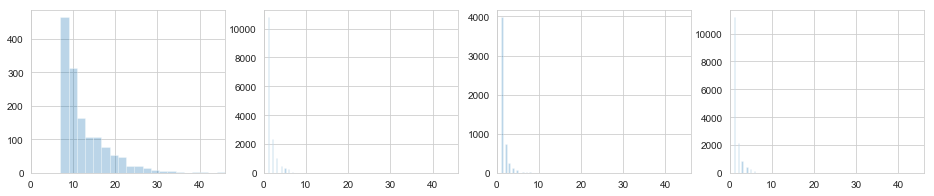

ave_revenue


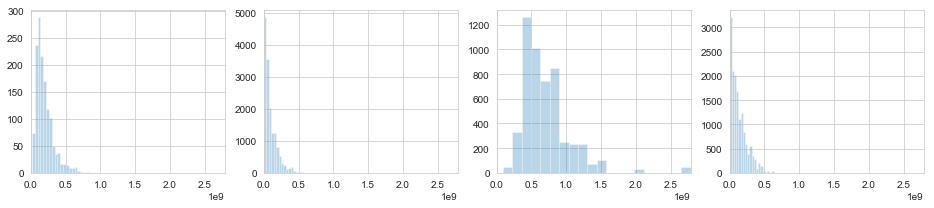

ave_budget


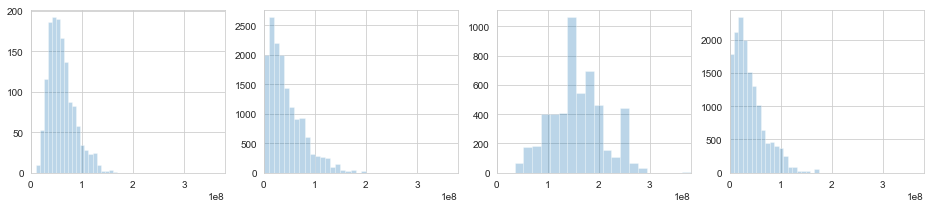

ave_count_vote


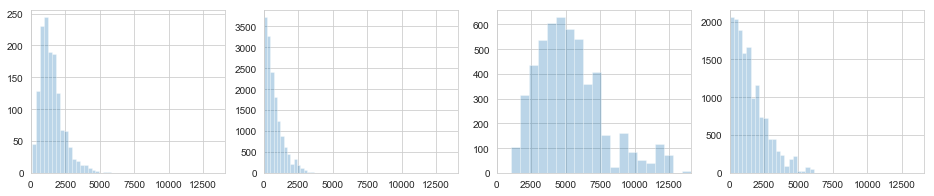

ave_vote


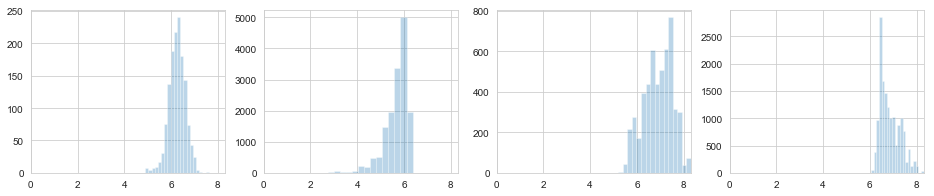

Adventure


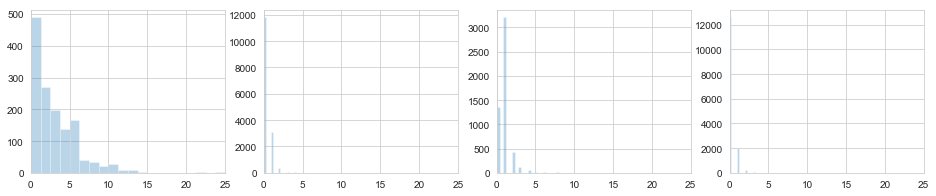

Animation


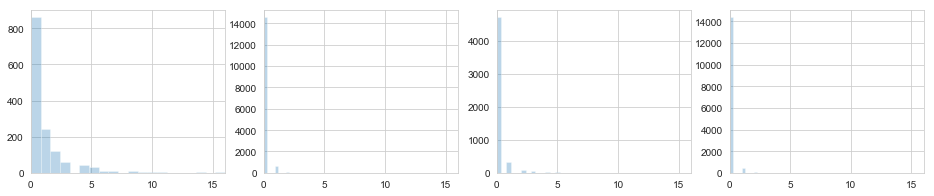

Comedy


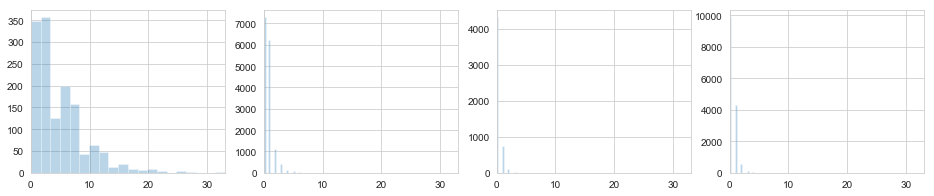

Drama


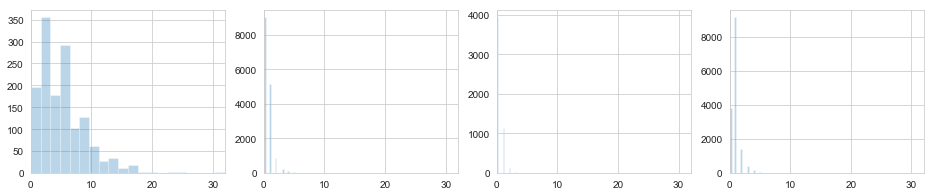

Family


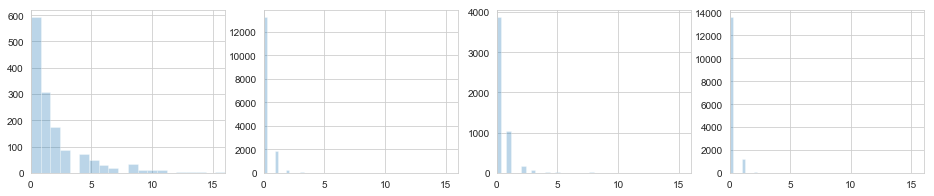

Horror


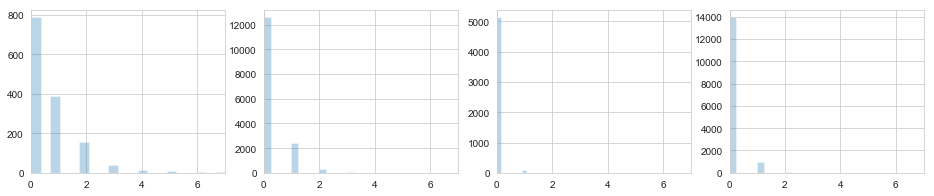

Music


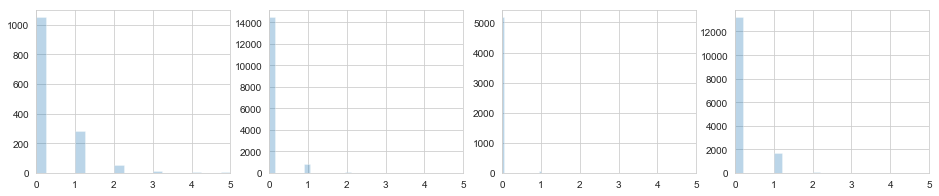

Science Fiction


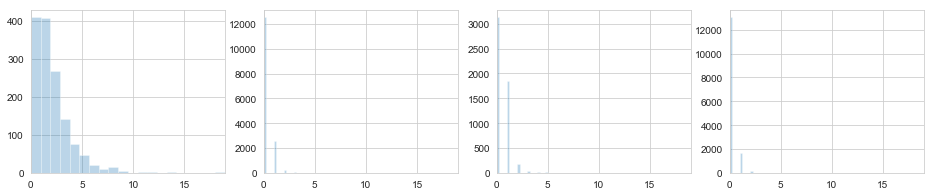

Thriller


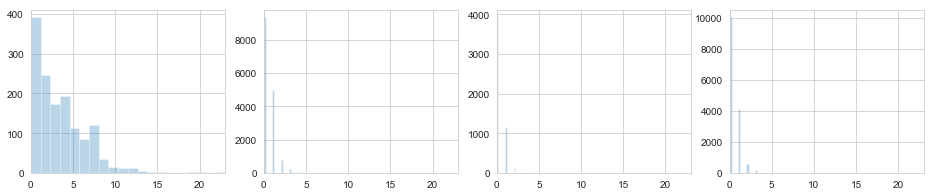

In [202]:
# Analyze the results
df_results = df_results.reset_index()
for cluster in sorted(set(model.labels_)):
    print(collections.Counter(df_results[df_results['cluster']==cluster]['num_movies']).most_common(5))

n_clusters = len(set(model.labels_))
for col in analize_columns:
    if col != 'name':
        print(col)
        i = 1
        plt.figure(figsize=(16,3))
        for cluster in sorted(set(model.labels_)):
            plt.subplot(1, n_clusters, i)
            plt.xlim([0,df_results[col].max()])
            plt.hist(df_results[df_results['cluster']==cluster][col], label=str(cluster), alpha=0.3, bins=20)
            i += 1
        plt.show()

In [208]:
print('Some actors from Cluster 3:')
df_results[(df_results['cluster'] == 3) & (df_results['num_movies'] < 6)][['name','num_movies']].sort_values(by='num_movies', ascending=False)

Some actors from Cluster 3:


,name,num_movies
32317,Simon Helberg,5
26845,Nora Zehetner,5
12710,Glenn Plummer,5
1895,Andrew Howard,5
35456,Valerie Tian,5
15777,Jeff Hochendoner,5
4954,Bryan Callen,5
33053,Steve Peacocke,5
16460,Jessica Williams,5
24732,Michael Jenn,5


# Model Evaluation

In [191]:
# Inter-Cluster
centroids = []
for cluster in sorted(set(model.labels_)):
    centroids.append(X[X['cluster']==cluster][X_columns].mean().values)
distances = []
for c1 in centroids:
    for c2 in centroids:
        distances.append(euclidean_distances(c1.reshape(-1, 1), c2.reshape(-1, 1))[0][0])
print('Inter Cluster distance', np.mean(distances))

# Intra-Cluster
distances = []
for cluster in sorted(set(model.labels_)):
    df_filter = X[X['cluster']==cluster]
    centroid = df_filter[X_columns].mean().values
    for k, v in df_filter[X_columns].iterrows():
        distances.append(euclidean_distances(centroid.reshape(-1, 1), v.values.reshape(-1, 1))[0][0])
print('Intra Cluster distance', np.mean(distances))

# Inertia
distances = []
for cluster in sorted(set(model.labels_)):
    df_filter = X[X['cluster']==cluster]
    centroid = df_filter[X_columns].mean().values
    for k, v in df_filter[X_columns].iterrows():
        distances.append(euclidean_distances(centroid.reshape(1, -1), v.values.reshape(1, -1), squared=True)[0][0])
print('Inertia', np.sum(distances))

Inter Cluster distance 1.845910416738601
Intra Cluster distance 0.34501416121389317
Inertia 93931.86366747582


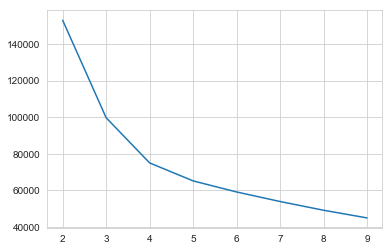

In [204]:
inertia = []
number_k = []
for k in range(2, 10, 1):
    kmeans = KMeans(n_clusters=k).fit(X.values)
    inertia.append(kmeans.inertia_)
    number_k.append(k)
plt.plot(number_k, inertia)
plt.show()

# Results

The elbow plot shows that three groups are optimal for our type of clustering but we want to try to explore more and chose k=4. 

General info for each group are presented in the table below based on calculated centroids. Genres are represented in percentage to the total number of movies for each group.

| Group name |Claster#| Num of movies | Ave revenue | Ave budget | Popularity | Ave vote | Adventure | Animation | Comedy | Drama | Family | Horror | Music | Science Fiction | Thriller |
| ------ |  ------ | ------ | ------ | ------ | ------ | ------ | ------ | ------ | ------ | ------ | ------ | ------ | ------ | ------ | ------ |
|Group 1|1|1.5     |94,078,700 |44,647,480     |731     |5.7  |17    |4|**46**|33    |10|**13**|4    |13    |30| 
|Group 2|3|1.5     |128,401,100|39,255,520     |**1484**|6.9  |12    |3|28    |**64**|7 |5     |**8**|10    |28|
|Group 3|2|1.4     |710,737,800|**158,857,400**|5284    |6.9  |**66**|1|15    |20    |26|1     |1    |**32**|20|
|Group 4|0|**11.9**|189,219,300|60,028,340     |1486    |6.2  |25    |9|40    |42    |15|6     |3    |14    |29|

### Group 1
Number of actors: 15329

Consists of actors with low amount of roles who played in generally lower budget movies with low popularity (based on number of votes). We can see that the percentage of comedies and horrors in this group is higher then in other groupes.

### Group 2
Number of actors: 14907

Consists of actors with low amount of roles with the same range of budget, revenue, but slightly higher popularity, vote average and revenue VS budget. In this group there are mostly dramas. The percentage of Music movies is higher then any other group.

### Group 3
Number of actors: 5213

Consists of actors with low amount of roles but with very hight budget and revenues. Based on these numbers along with high popularity we can assume that these actors played in succesful series of movies but didn't play much more of other roles (we saw few actors from Harry Potter, Dexter, animation voice actors). The Adventure genre leads in this group. 

### Group 4
Number of actors:  1407

Actors who played in many movies (app. 6 to 45). Numbers in this group are relatively average as there were good and bad productions, also because there are more then 1407 actors that includes not only the top 200-500 but much more. We could try to create more clusters and see whether we will be able to devide this group into two or three others.